In [6]:
import pandas as pd
import numpy as np
import random
from transformers import GPT2Tokenizer, GPT2LMHeadModel, GPT2TokenizerFast
import csv
import os
import evaluate
from nltk.translate.bleu_score import sentence_bleu
import torch
from tqdm import tqdm, trange

In [7]:
pd.set_option("max_colwidth", 400)

In [8]:
from google.colab import drive

drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [9]:
path = "drive/MyDrive/EHU/Apps1/final_project"

In [6]:
df = pd.read_csv(
    f"{path}/data/reseted_test_predictions.csv",
    usecols=["artist", "song", "tag_2", "Lyric", "True_end_lyrics", "Generated Lyrics"],
)

In [7]:
df = df.rename(
    columns={
        "True_end_lyrics": "true_end_lyrics",
        "Generated Lyrics": "generated_lyrics",
        "Lyric": "source_lyrics",
        "tag_2": "tag",
    }
)

In [8]:
df["generated_lyrics"] = df["generated_lyrics"].str.replace("<|endoftext|>", "")
df["generated_end_lyrics"] = df.apply(
    lambda row: row["generated_lyrics"].replace(row["source_lyrics"], ""), axis=1
)

In [9]:
df.head()

,artist,song,source_lyrics,tag,true_end_lyrics,generated_lyrics,generated_end_lyrics
0,5 Seconds of Summer,No Shame,"Angel, with the gun in your hand",[Verse],"Pointin' my direction, givin' me affection Love is fatal, won'tyougive it achance? Center of attention, don't you askme any questions","Angel, with the gun in your hand, looking back at you. I don't know if she likes me.\nLars, my daughter, in this bed with you. You were",", looking back at you. I don't know if she likes me.\nLars, my daughter, in this bed with you. You were"
1,5 Seconds of Summer,No Shame,Go on and light me like a cigarette,[Pre-Chorus],"Even if it might be somethin' you regret You got me now, now, now Swallow me down, down, down, down","Go on and light me like a cigarette as I am made fun of. One could argue the habit exists for so long that it might just go away.\n""But I'm still not","as I am made fun of. One could argue the habit exists for so long that it might just go away.\n""But I'm still not"
2,5 Seconds of Summer,No Shame,I only light up when cameras are flashin' Never enough and no satisfaction Got no shame I love the way you're screaming my name Diggin' my grave to get,[Chorus],a reaction Changin' my face and callin' it fashion Got no shame I love the way you're screaming my name,"I only light up when cameras are flashin' Never enough and no satisfaction Got no shame I love the way you're screaming my name Diggin' my grave to get me back where I belong' Got no shame, mama I'm showin' her what she wants' Keep your eyes open for me and let","me back where I belong' Got no shame, mama I'm showin' her what she wants' Keep your eyes open for me and let"
3,5 Seconds of Summer,No Shame,"Lay me in the palm of your hand I'll give you my permission, you'll always be forgiven Go on, replace me When you're cravin'",[Verse],somethin' sweeter than the words I left in your mouth Go on and spit me out You might also like,"Lay me in the palm of your hand I'll give you my permission, you'll always be forgiven Go on, replace me When you're cravin' in the kitchen, do whatever you need As a husband to love me love me go\nIt's all been a dream come true for you Go on","in the kitchen, do whatever you need As a husband to love me love me go\nIt's all been a dream come true for you Go on"
4,5 Seconds of Summer,No Shame,I only light up when cameras are flashin' Never enough and no satisfaction Got no shame I love the way you're screaming my name Diggin' my grave to get,[Chorus],a reaction Changin' my face and callin' it fashion Got no shame I love the way you're screaming my name,"I only light up when cameras are flashin' Never enough and no satisfaction Got no shame I love the way you're screaming my name Diggin' my grave to get where I am (It's in my mind, it's in my heart) Ooh-ooh It's good to know I'm not alone","where I am (It's in my mind, it's in my heart) Ooh-ooh It's good to know I'm not alone"


# BLEU

In [10]:
reference = [x.split() for x in df["true_end_lyrics"].to_list()]
df["bleu_score"] = df["generated_end_lyrics"].map(lambda x: sentence_bleu(reference, x))

/usr/local/lib/python3.10/dist-packages/nltk/translate/bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 2-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/usr/local/lib/python3.10/dist-packages/nltk/translate/bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/usr/local/lib/python3.10/dist-packages/nltk/translate/bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_

In [11]:
device = "cpu"
model_id = f"{path}/data/model_gpt"
model = GPT2LMHeadModel.from_pretrained(model_id).to(device)
tokenizer = GPT2TokenizerFast.from_pretrained("gpt2")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


<Axes: ylabel='tag'>

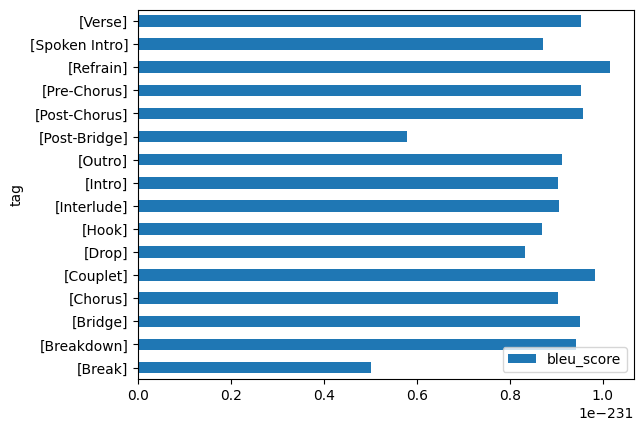

In [30]:
df[["tag", "bleu_score"]].groupby(["tag"]).mean().plot(kind="barh")

In [32]:
mean_bleu_by_artist = (
    df[["artist", "bleu_score"]]
    .groupby(["artist"])
    .mean()
    .reset_index()
    .sort_values(by=["bleu_score"])
)

In [35]:
mean_bleu_by_artist[:5]

,artist,bleu_score
79,Rihanna,6.191535e-232
81,Sabrina Carpenter,7.822288e-232
78,Phil Collins,7.913880e-232
97,Zara Larsson,7.941678e-232
44,Jeremy Zucker,8.037498e-232


In [37]:
mean_bleu_by_artist[-5:][::-1]

,artist,bleu_score
99,blackbear,1.049909e-231
15,Boyce Avenue,1.020814e-231
19,Camila Cabello,1.019906e-231
65,Mark Ronson,1.013346e-231
17,Bruno Mars,1.012838e-231


# Perplexity

In [13]:
perplexity = evaluate.load("perplexity", module_type="metric")

In [14]:
df = df[df.generated_end_lyrics != ""]
input_texts = df["generated_end_lyrics"].to_list()
input_texts = [x.lstrip() for x in input_texts]

In [15]:
perplexity_results = perplexity.compute(
    model_id=f"{path}/data/model_gpt", predictions=input_texts
)

  0%|          | 0/50 [00:00<?, ?it/s]

In [16]:
df["perplexity"] = perplexity_results["perplexities"]

<ipython-input-16-b3470a07c9e3>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['perplexity'] = perplexity_results['perplexities']


In [17]:
df.to_csv(f"{path}/metrics_evaluation_results.csv", index=False)

In [10]:
df = pd.read_csv(f"{path}/metrics_evaluation_results.csv")

<Axes: ylabel='tag'>

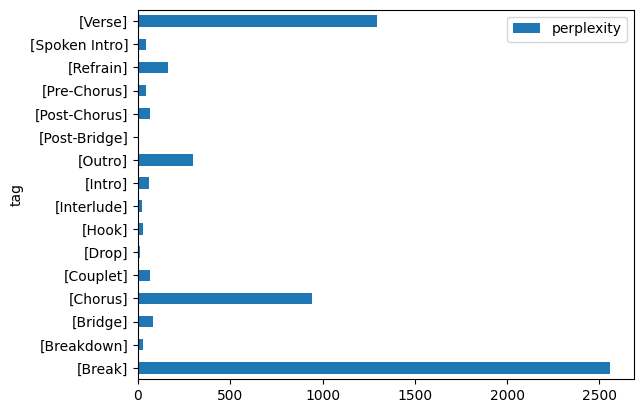

In [11]:
df[["tag", "perplexity"]].groupby("tag").mean().plot(kind="barh")

In [12]:
interesting_cols = [
    "artist",
    "song",
    "source_lyrics",
    "true_end_lyrics",
    "generated_end_lyrics",
    "bleu_score",
    "perplexity",
]

In [13]:
df[df.perplexity == max(df.perplexity)][interesting_cols]

,artist,song,source_lyrics,true_end_lyrics,generated_end_lyrics,bleu_score,perplexity
648,Sabrina Carpenter,Thumbs,Somewhere in the world They think they're working for themselves They get up every day to go to work for someone else And somebody works for,"them And so, they think they've got it made But they're all just working to get paid the very same",them,6.065720e-233,249400.421875


In [14]:
df[df.perplexity == min(df.perplexity)][interesting_cols]

,artist,song,source_lyrics,true_end_lyrics,generated_end_lyrics,bleu_score,perplexity
629,Rihanna,Work,"Work, work, work, work, work, work He said me haffi Work, work, work, work, work, work He see me do mi Dirt, dirt, dirt, dirt, dirt, dirt So me put in Work, work, work, work, work,","work When you ah guh Learn, learn, learn, learn, learn? Me nuh cyar if him Hurt, hurt, hurt, hurt, hurting","work, work, work, work, work, work, work, work, work, work, work, work, work, work, work,",0.0,1.949132
633,Rihanna,Work,"Work, work, work, work, work, work He said me haffi Work, work, work, work, work, work He see me do mi Dirt, dirt, dirt, dirt, dirt, dirt So me put in Work, work, work, work, work,","work When you ah guh Learn, learn, learn, learn, learn? Me nuh cyar if him Hurt, hurt, hurt, hurt, hurting","work, work, work, work, work, work, work, work, work, work, work, work, work, work, work,",0.0,1.949132


We can see that the prediction that has the lowest perplexity is the repetition of the word "work". Curiously enough, due to the nature of the song, it is not really a bad prediction.

In [15]:
mean_perplexity_by_artist = (
    df[["artist", "perplexity"]]
    .groupby(["artist"])
    .mean()
    .reset_index()
    .sort_values(by=["perplexity"])
)

In [18]:
mean_perplexity_by_artist[:5]

,artist,perplexity
91,Tones And I,18.558754
94,Vance Joy,18.681752
22,Charlie Puth,18.908140
4,Alessia Cara,19.118593
14,Black Eyed Peas,19.189764


In [26]:
df[df.artist == "Tones And I"][interesting_cols]

,artist,song,source_lyrics,true_end_lyrics,generated_end_lyrics,bleu_score,perplexity
721,Tones And I,Dance Monkey,"They say, ""Oh my god, I see the way you shine Take your hands, my dear, and place them both in mine"" You know you",stopped me dead while I was passing by And now I beg to see you dance just one more time,don't like it when my hands are on you and your eyes are in mine. I know you don't like it when my eyes are on you,9.049162e-232,10.947695
722,Tones And I,Dance Monkey,"Ooh, I see you, see you, see you every time And oh my, I, I, I like your style You, you","make me, make me, make me wanna cry And now I beg to see you dance just one more time","can't do that No, you can't do that\nYou don't even wanna play, what do you want?",9.877831e-232,17.036236
723,Tones And I,Dance Monkey,"So they say ""Dance for me, dance for me, dance for me, oh-oh-oh I've never seen anybody do the things you do before"" They say ""Move","for me, move for me, move for me, eh-eh-eh And when youre done, I'll make you do it all again""","me, dance for me, dance for me, dance for me, oh-oh-oh-oh I've never seen anyone dance for me before",8.593508e-232,9.940865
724,Tones And I,Dance Monkey,"I said, ""Oh my god, I see you walking by Take my hands, my dear, and look me in my eyes"" Just like a monkey, I've been",dancin my whole life But you just beg to see me dance just one more time You might also like,"staring at you for five minutes, do I really have to remind myself to be grateful?\nDo you feel a connection with me?",9.316105e-232,20.547380
725,Tones And I,Dance Monkey,"Ooh, I see you, see you, see you every time And oh my, I, I, I like your style You, you","make me, make me, make me wanna cry And now I beg to see you dance just one more time",", see you, see you, I, I, I like your style",1.063858e-231,50.561413
726,Tones And I,Dance Monkey,"So they say ""Dance for me, dance for me, dance for me, oh-oh-oh I've never seen anybody do the things you do before"" They say ""Move for me, move for me, move for me, eh-eh-eh And when you're done, I'll make you do it all again"" They say ""Dance for me, dance for me, dance for me, oh-oh-oh, oh-oh, oh-oh I've never seen anybody do the things you do before"" They say ""Move","for me, move for me, move for me, eh-eh-eh And when you're done, I'll make you do it all again""","for me, move for me, dance for me, oh-oh-oh, oh-oh, oh-oh""",6.573480e-232,9.787698
727,Tones And I,Dance Monkey,"They say ""Dance for me, dance for me, dance for me, oh-oh-oh I've never seen anybody do the things you do before"" They say ""Move for me, move for me, move for me, eh-eh-eh And when youre done, Ill make you do it all again"" They say ""Dance for me, dance for me, dance for me, oh-oh-oh, oh-oh, oh-oh I've never seen anybody do the things you do before"" They say ""Move for me,","move for me, move for me, eh-eh-eh And when youre done, I'll make you do it all again All again""","dance for me, dance for me, oh-oh-oh, oh-oh, oh-oh I've never seen anyone do the things you",8.796378e-232,11.089989


We observe that the lyrics with low perplexity tend to occur in lyrics where some word is constantly repeated (see Rihanna's "Work" song prediction in which the model only predicted the word "Work"). In the case of the samples above, we can see "oh", "I" and "you".

In [19]:
mean_perplexity_by_artist[-5:][::-1]

,artist,perplexity
44,Jeremy Zucker,48403.167229
81,Sabrina Carpenter,22732.881243
90,Tom Odell,5122.916069
58,Lewis Capaldi,1827.570341
39,James Arthur,1643.320029


Interestingly enough, we can see that the artists with higher perplexity results are artists that tend to sing about sad topics: Jeremy Zucker, Tom Odell, Lewis Capaldi and James Arthur. Having a high perplexity is a "good sign" in the sense that the model has been able to capture that this type of lyrics are usually more elaborated and complex than the ones found in happy and plain pop songs.

In [25]:
df[df.artist == "Jeremy Zucker"][interesting_cols]

,artist,song,source_lyrics,true_end_lyrics,generated_end_lyrics,bleu_score,perplexity
371,Jeremy Zucker,"​always, i’ll care","Often, Iget exhausted",Trying regardless to be enough Isit selfish not to be selfless When all I can help is to open up?,"\nAnd Igo to bed\nI'm in the rain (That's me crying right now, baby)\nI'm just trying to stay alive",1.059958e-231,23.901499
372,Jeremy Zucker,"​always, i’ll care",I'll be better than I was before Despite every text,"of yours ignored Will you call me still, just to hear my voice? I swear, always, I'll care I'll care",message,2.417097e-232,193549.093750
373,Jeremy Zucker,"​always, i’ll care","Leave me, it's never easy I've had a lifetime to be alone","If you let me, when it gets heavy No, I'll never let you be all alone You might also like",".\n|[Bridge]|-Y'know, I might have come from the darkest place in the world to find you\nIt was all",1.032322e-231,13.426636
374,Jeremy Zucker,"​always, i’ll care",I'll be better than I was before (Hey) Despite every text of,"yours ignored (Hey) Will you call me still, just to hear my voice? I swear, always Always Always, I'll care","affection and devotion to me in the week and a half I've been listening to you, because you're my champion, my God, my fire and",8.810090e-232,26.247030


# Ask your own lyrics

To get our own lyrics, we will recover our `generate` function and use it.

In [41]:
tokenizer = GPT2TokenizerFast.from_pretrained(f"{path}/data/model_gpt")
model = GPT2LMHeadModel.from_pretrained(f"{path}/data/model_gpt")

In [54]:
def generate(
    model,
    tokenizer,
    prompt,
    entry_count=10,
    entry_length=30,  # maximum number of words
    top_p=0.8,
    temperature=1.0,
):
    model.eval()
    generated_num = 0
    generated_list = []

    filter_value = -float("Inf")

    with torch.no_grad():

        for entry_idx in trange(entry_count):

            entry_finished = False
            generated = torch.tensor(tokenizer.encode(prompt)).unsqueeze(0)

            for i in range(entry_length):
                outputs = model(generated, labels=generated)
                loss, logits = outputs[:2]
                logits = logits[:, -1, :] / (temperature if temperature > 0 else 1.0)

                sorted_logits, sorted_indices = torch.sort(logits, descending=True)
                cumulative_probs = torch.cumsum(
                    F.softmax(sorted_logits, dim=-1), dim=-1
                )

                sorted_indices_to_remove = cumulative_probs > top_p
                sorted_indices_to_remove[..., 1:] = sorted_indices_to_remove[
                    ..., :-1
                ].clone()
                sorted_indices_to_remove[..., 0] = 0

                indices_to_remove = sorted_indices[sorted_indices_to_remove]
                logits[:, indices_to_remove] = filter_value

                next_token = torch.multinomial(F.softmax(logits, dim=-1), num_samples=1)
                generated = torch.cat((generated, next_token), dim=1)

                if next_token in tokenizer.encode("<|endoftext|>"):
                    entry_finished = True

                if entry_finished:

                    generated_num = generated_num + 1

                    output_list = list(generated.squeeze().numpy())
                    output_text = tokenizer.decode(output_list)
                    generated_list.append(output_text)
                    break

            if not entry_finished:
                output_list = list(generated.squeeze().numpy())
                output_text = f"{tokenizer.decode(output_list)}<|endoftext|>"
                generated_list.append(output_text)

    return generated_list

In [55]:
# Function to generate multiple sentences. Test data should be a dataframe
def text_generation(test_data):
    generated_lyrics = []
    for i in range(len(test_data)):
        x = generate(model.to("cpu"), tokenizer, test_data[i], entry_count=1)
        generated_lyrics.append(x)
    return generated_lyrics

In [62]:
generated_lyrics = text_generation(["The stars were shining \n your eyes were crying"])

100%|██████████| 1/1 [00:10<00:00, 10.72s/it]


In [65]:
print(generated_lyrics[0][0])

The stars were shining 
 your eyes were crying out for my happiness

That night I was on the road

I loved you with my life and now I'm in love

I<|endoftext|>


We can see that the model can generate lyric-like structures, with a jargon similar to the pop songs of nowadays (simple and plain). There is still a lot of room for improvement, for instance:

1. Longer training. Due to time constrictions and computational limitations, we could only train for 5 epochs.
2. Training with more powerful machines. Again, the lack of resources limited our work and our possible findings.
3. Enlarge the dataset: we only took 10 songs by artists but we could expand it to all the songs by all artists. Also, the number of artists could be increased as well as try out more genres than pop.
4. Developing a system with rhyme control. We have just finetuned the model with songs in English without any control of the rhyme. In some cases the model seems to be able to rhyme some of the verses, however, it is probably due to the fact that English is a language "easy to rhyme" and the set of words in pop songs is usually the same rather than the model having achieved the capacity to rhyme.